# Levenshtein distance between synthetic data and student programs

In this notebook, we will train our classifier on synthetic data and run the classification task on student programs.

We use grammars that represent the probabilistic distribution of student solutions. Given that in the process of developing these grammars we referenced the students programs, in this notebook we compute the minimum edit distance between the synthetic data generated by our grammars and the original student solutions. 

With that, we will be able to evaluate which portion of our validation set may be present in our training set, and to what extent. 

First we set up the packages we'll need to use, as well as the local repositories of student data:

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('..')

In [4]:
from autoplan.trainer import ClassifierTrainer
from autoplan.dataset import PrelabeledDataset, build_synthetic_dataset, build_prelabeled_dataset
from autoplan.generator import ProgramGenerator
from autoplan.vis import plot_accuracy, plot_cm, plot_loss
from autoplan.token import TokenType, PyretTokenizer, OCamlTokenizer
from scripts.rainfall_ingest import ingest_dataset

from grammars.rainfall.ocaml import Program
from grammars.rainfall.labels import GeneralRainfallLabels

from tqdm import tqdm_notebook as tqdm
import pandas as pd
import torch
import os
import numpy as np
import torch.nn as nn
from pprint import pprint
import nltk

device = torch.device('cpu')
# device = torch.device('cuda:0')
REPO_DIR = os.path.expanduser('~/autoplan')

# Student dataset

In this section, we specify and ingest the dataset of students' OCaml solutions, as well as the hyperparameters for dataset treatment that we are going to use. 

Based on the previous ablation study [1] we learned that preprocessing the student dataset positively influences the classification accuracy, so we choose to preprocess student data. Additionally, we choose to normalize all identifiers (strings), as we believe the classifier should not learn to differentiate between them. 

In [5]:
dataset_name = 'T1'
student_dataset = ingest_dataset(dataset_name)

In [70]:
# Run this cell optionally to see a sample of a student program
print(student_dataset.dataset[0]['source'])

let rec rainfall (alof : float list) =
  (let rec sum_helper (alof : float list) (sum : float) (counter : float) =
     (match (alof, counter) with
      | ([],0.) -> failwith "Empty list."
      | ((-999.)::_,0.) -> failwith "Empty list."
      | ([],_) -> (sum, counter)
      | ((-999.)::_,_) -> (sum, counter)
      | (hd::tl,_) ->
          if hd >= 0.
          then sum_helper tl (sum +. hd) (counter +. 1.)
          else sum_helper tl sum counter : (float* float)) in
   match sum_helper alof 0. 0. with | (s,c) -> s /. c : float)



# Synthetic dataset

In this section, we specify and generate the dataset of synthetic OCaml solutions. As such, we specify the number of samples we wish to generate, the grammar we would like to generate samples from, the labels that are used to classify these samples, as well as adaptive and unique sampling -- two hyperparameters that can be dynamically set by the user to influence dataset diversity.   

Adaptive sampling is a dataset generating technique first described in [2], where dominant choices are dynamically penalized, such that rare programs are more likely to be generated within the same batch. 

Unique sampling simply forces the generator to generate unique samples.  

In [18]:
N_samples = 5
synthetic_dataset = build_synthetic_dataset(
    GeneralRainfallLabels,
    N=N_samples,
    tokenizer=OCamlTokenizer(),
    generator=ProgramGenerator(grammar=Program(), adaptive=False),
    vocab_index=student_dataset.vocab_index,
    unique=False)

Generating programs...
Generated 5 unique programs.
Tokenizing programs...
Building dataset metadata...


In [7]:
# Run this cell optionally to see a sample program generated from our grammar
print(synthetic_dataset.dataset[1]['source'])

let rec rainfall list_name =
  try
    (List.fold_right
       (fun var  ->
          fun var  ->
            if var = (-999) then 0. else if var < 0 then var else var + var)
       list_name 0)
      /.
      (List.fold_right
         (fun var  ->
            fun var  ->
              if var = (-999) then 0. else if var < 0 then var else 1 + var)
         list_name 0)
  with
  | division_by_zero_helper_name ->
      failwith "invalid input (ocaml needed this wildcard for some reason)"



# Model

In this section, we specify which classification model we are going to use and specify the hyperparameters configuration. Based on our previous ablation study [1], we choose GRU or LSTM, and a size of 512 for both the hidden layer and the embedding. 

In [13]:
model_options = {
    'model' : nn.GRU,
    'hidden_size' : 512,
    'embedding_size' : 512
}

trainer = ClassifierTrainer(synthetic_dataset, device, model_opts=model_options)

In [14]:
# TODO: Add student evaluation over epoch

losses = []
train_eval = []
val_eval = []
# student_eval = []

for _ in tqdm(range(50)):
    losses.append(trainer.train_one_epoch())
    train, val = trainer.eval()
    train_eval.append(train)
    val_eval.append(val)

# Evaluation

In this section we analyze the performance of our model. 

First we look how loss varied at each epoch. Loss refers to the distance between the predicted label and the true label. 

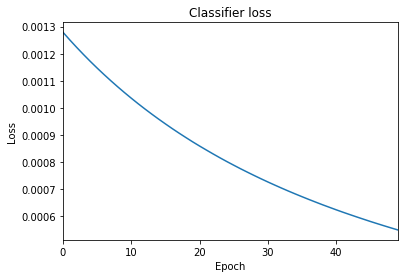

In [88]:
plot_loss(losses, title='Classifier loss')

Second we look at the model accuracy at each epoch, as evaluated on the training set and the evaluation set. 

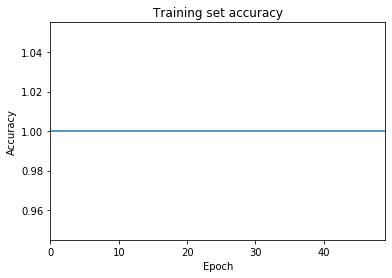

In [87]:
plot_accuracy(train_eval, title='Training set accuracy')

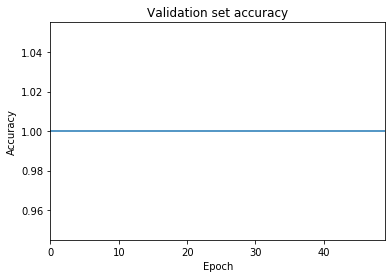

In [86]:
plot_accuracy(val_eval, title='Validation set accuracy')

Finally, we look at the confusion matrix for the label prediction. Specifically, we look at what percentage of the true labels our model correctly predicted. 

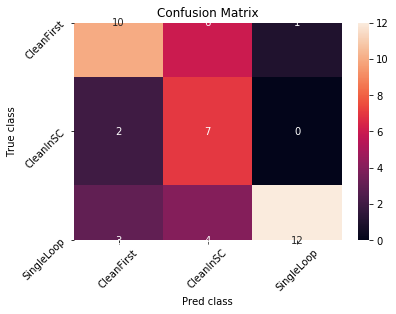

In [94]:
trainer.model.eval()
trainer.eval_on(student_dataset.loader(student_dataset.dataset)).plot_cm("Confusion Matrix", normalize=False)

# Levenshtein Distance between synthetic and student data

In this section, we calculate the minimum edit distance between each student solution and all synthetic samples. We compute the edit distance both with respect to the source program and the tokenized program.   

In [26]:
# Edit distance with respect to the source code:
from iterextras import par_for

N=N_samples
edit_distance = {}

# For each student solution
for student_program in range(len(student_dataset.dataset)):
    print("Analyzing student answer #", student_program, "...")
    student_answer = student_dataset.dataset[student_program]['source']
    student_tokens = student_dataset.dataset[student_program]['program']
    
    # Calculate the edit distance with respect to each synthetic solution and keep the minimum
    def compute_source_dist(j): 
        synthetic_program = synthetic_dataset.dataset[j]['source']
        source_levenshtein_distance = nltk.edit_distance(student_answer, synthetic_program, transpositions=False)
        return source_levenshtein_distance
    
    def compute_token_dist(j): 
        synthetic_tokens = synthetic_dataset.dataset[j]['program']
        token_levenshtein_distance = nltk.edit_distance(student_tokens, synthetic_tokens, transpositions=False)
        return token_levenshtein_distance
    
    source_dists = par_for(compute_source_dist, list(range(N)), process=True, progress=False)
    token_dists = par_for(compute_token_dist, list(range(N)), process=True, progress=False)
    
    edit_distance[student_program] = (min(source_dists), np.argmin(source_dists), min(token_dists), np.argmin(token_dists))

Analyzing student answer # 0 ...
Analyzing student answer # 1 ...
Analyzing student answer # 2 ...
Analyzing student answer # 3 ...
Analyzing student answer # 4 ...
Analyzing student answer # 5 ...
Analyzing student answer # 6 ...
Analyzing student answer # 7 ...
Analyzing student answer # 8 ...
Analyzing student answer # 9 ...
Analyzing student answer # 10 ...
Analyzing student answer # 11 ...
Analyzing student answer # 12 ...
Analyzing student answer # 13 ...
Analyzing student answer # 14 ...
Analyzing student answer # 15 ...
Analyzing student answer # 16 ...
Analyzing student answer # 17 ...
Analyzing student answer # 18 ...
Analyzing student answer # 19 ...
Analyzing student answer # 20 ...
Analyzing student answer # 21 ...
Analyzing student answer # 22 ...
Analyzing student answer # 23 ...
Analyzing student answer # 24 ...
Analyzing student answer # 25 ...
Analyzing student answer # 26 ...
Analyzing student answer # 27 ...
Analyzing student answer # 28 ...
Analyzing student answer

In [27]:
# Run this cell optionally to see the minimum distance of each student solution and the index of its nearest synthetic program
""" 
Format: {student_program: 
        (minimum source code distance, nearest source code, minimum token distance, nearest tokenized code)
        }"""

pprint(edit_distance)

{0: (355, 1, 89, 1),
 1: (338, 0, 58, 2),
 2: (422, 4, 60, 2),
 3: (309, 2, 69, 2),
 4: (443, 4, 64, 2),
 5: (296, 2, 60, 2),
 6: (288, 2, 58, 1),
 7: (294, 2, 66, 2),
 8: (284, 2, 60, 2),
 9: (362, 2, 90, 1),
 10: (285, 2, 57, 2),
 11: (279, 2, 50, 2),
 12: (308, 2, 78, 2),
 13: (383, 1, 69, 2),
 14: (349, 0, 85, 3),
 15: (259, 2, 42, 2),
 16: (293, 2, 60, 4),
 17: (238, 0, 30, 3),
 18: (266, 0, 41, 1),
 19: (394, 3, 84, 3),
 20: (415, 4, 83, 1),
 21: (280, 1, 41, 1),
 22: (273, 3, 51, 3),
 23: (275, 2, 40, 4),
 24: (295, 3, 55, 3),
 25: (262, 2, 36, 2),
 26: (333, 1, 58, 1),
 27: (246, 1, 35, 1),
 28: (205, 0, 19, 3),
 29: (347, 1, 71, 1),
 30: (1519, 4, 391, 1),
 31: (574, 3, 84, 3),
 32: (311, 1, 56, 1),
 33: (189, 4, 5, 4),
 34: (270, 2, 50, 2),
 35: (296, 0, 54, 0),
 36: (272, 1, 39, 1),
 37: (315, 0, 63, 3),
 38: (486, 4, 83, 4),
 39: (390, 4, 83, 3),
 40: (314, 0, 73, 3),
 41: (324, 1, 64, 1),
 42: (418, 1, 91, 1),
 43: (298, 0, 75, 3),
 44: (342, 0, 70, 3)}


# Levenshtein Distance between training and validation synthetic sets

In this section, we calculate the minimum edit distance between each training sample and all validation samples. We compute the edit distance both with respect to the source sample and the tokenized sample.  

In [ ]:
# TODO: add parallelism (i.e. add a function, then call it later)

# Edit distance with respect to the source code:
edit_distance = {}

for train in trainer.train_loader:
    for i in train:
        train_programs = train['source']
        for train_solution in train_programs:
            print("Analyzing a new training sample...")
            min_distance = 10000 # arbitrarily large value
            for val in trainer.val_loader:
                for j in val:
                    val_programs = val['source']
                    for val_solution in val_programs:
                        levenshtein_distance = nltk.edit_distance(train_solution, val_solution, transpositions=False)
                        if levenshtein_distance < min_distance:
                            min_distance = levenshtein_distance
                            nearest_program = val_solution
    
            edit_distance[train_solution] = [nearest_program, min_distance]

In [ ]:
# Run this cell optionally to see each training sample and the nearest validation sample
for i in edit_distance:
    print("Training sample:")
    pprint(i)
    print("Nearest validation sample:")
    pprint(edit_distance[i])

In [ ]:
# TODO: add parallelism (i.e. add a function, then call it later)

# Edit distance with respect to the tokenized program:
edit_distance = {}

for train in trainer.train_loader:
    for i in train:
        train_programs = train['program']
        for train_solution in train_programs:
            print("Analyzing a new training sample...")
            min_distance = 10000 # arbitrarily large value
            for val in trainer.val_loader:
                for j in val:
                    val_programs = val['program']
                    for val_solution in val_programs:
                        levenshtein_distance = nltk.edit_distance(train_solution, val_solution, transpositions=False)
                        if levenshtein_distance < min_distance:
                            min_distance = levenshtein_distance
                            nearest_program = val_solution
    
            edit_distance[train_solution] = [nearest_program, min_distance]

In [ ]:
# TODO: Edit visualization

# Run this cell optionally to see each training sample and the nearest validation sample
for i in edit_distance:
    print("Training sample:")
    pprint(i)
    print("Nearest validation sample:")
    pprint(edit_distance[i])

# Conclusion

Hello World

# References

1. Ablation study (# TODO: add link)
2. GG_NAP (# TODO: add link)